### [Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html)
- Generic supervised method
- Advantages:
    - The prediction interpolates the observations (at least for regular kernels).
    - The prediction is probabilistic (Gaussian) - you can find empirical confidence intervals & decide you should refit to a region of interest.
    - Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.
- Disadvantages:
    - Scikit-learn implementation is not sparse. It uses all samples/features information to perform the prediction.
    - Gaussians lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozen.

### [Gaussian Process Regression (GPR)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor)
- The prior of the GP needs to be specified. GP combines the prior and a likelihood function based on training samples. It provides a mean and standard deviation when predicting.
- The __prior mean__ is assumed to be constant and zero (``normalize_y=False``) or the training data’s mean (``normalize_y=True``).
- The __prior's covariance__ is specified by passing a __kernel__ object.
    - The kernel hyperparameters are optimized during fitting by maximizing the __log-marginal-likelihood (LML)__ based on the optimizer.
    - The LML may have multiple local optima - the optimizer can be restarted with ``n_restarts_optimizer``.
    - The first run always uses the kernel's initial hyperparameter values.
    - Subsequent runs use hyperparameter values chosen randomly from the range of allowed values.
    - If the initial hyperparameters should be kept fixed, ``None`` can be passed as optimizer.

- The noise level in the targets can be specified with ``alpha``, either globally as a scalar or per datapoint.
    - A moderate noise level can be helpful for dealing with numeric instabilities during fitting - it is effectively implemented as __Tikhonov regularization__, i.e., by adding it to the diagonal of the kernel matrix.
    - An alternative to explicit noise levels - include a ``WhiteKernel`` component to the kernel, which can estimate a global noise level from the data.

### [Example: GPR & noise levels](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)
- Demonstrates how GPR with a sum kernel can estimate noise level in a dataset.
- A simple one-dimensional regression example computed in two different ways:
    - A noise-free case
    - A noisy case with known noise-level per datapoint
- In both cases, the kernel’s parameters are estimated using the maximum likelihood principle.
- The figures illustrate the interpolating property of the Gaussian Process model as well as its probabilistic nature in the form of a pointwise 95% confidence interval.
- ``alpha`` controls the strength of the __Tikhonov regularization__ on the training data covariance matrix.

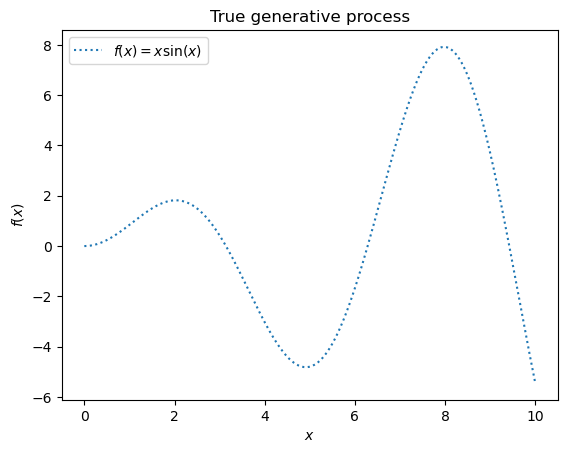

In [1]:
# synthetic dataset
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [2]:
# first, a noise-free target. only using a few samples.
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [3]:
# fit using an RBF kernel and constant 
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

kernel           = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GPR(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

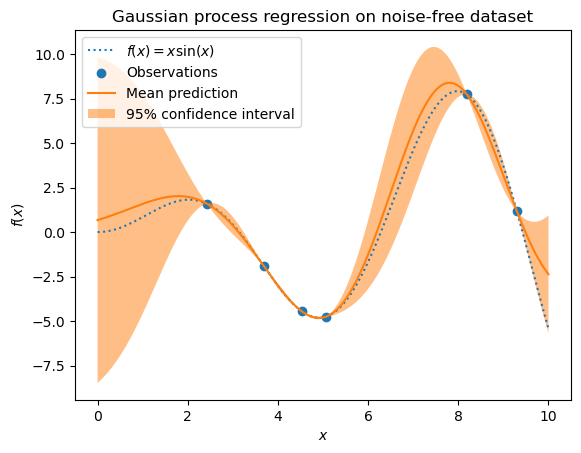

In [4]:
# use kernel to predict entire dataset & 95% confidence interval
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")rng = np.random.RandomState(1)
training_irng = np.random.RandomState(1)
training_irng = np.random.RandomState(1)
training_i

In [5]:
# add random gaussian noise
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

# create model - add alpha = variance of a Gaussian noise.
gaussian_process = GPR(kernel=kernel, 
                       alpha=noise_std**2, 
                       n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

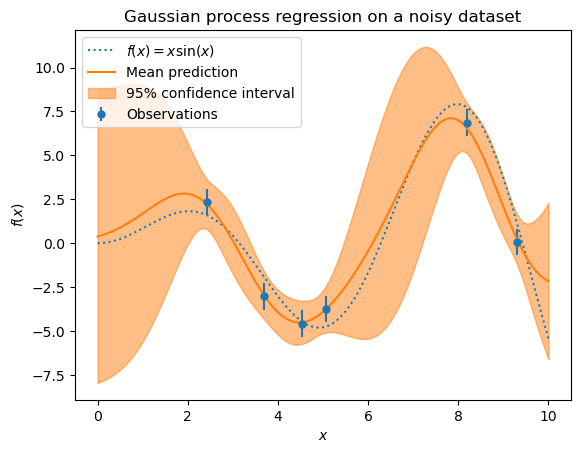

In [6]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

- The noise affects the predictions close to the training samples.

### [example: using GPR to estimate noise levels](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py)

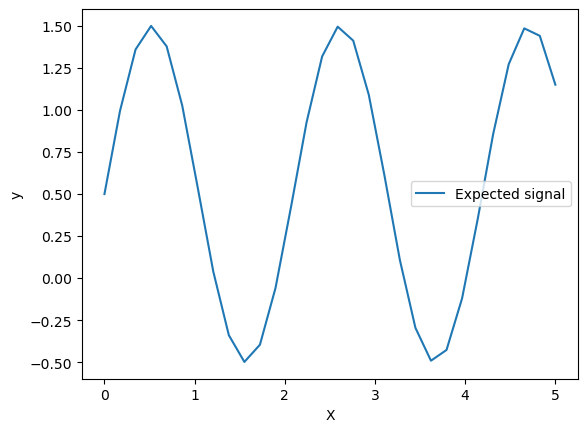

In [8]:
# setup: X will contain a single feature. 
# create a function that generates the target to be predicted. We will add an option to add some noise to the generated target.

import numpy as np

def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

# target generator - not adding noise (to observe the signal we want to predict)

X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

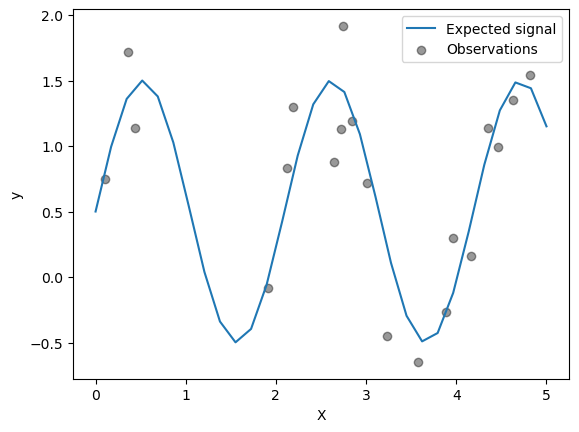

In [9]:
# generate noisy samples & illustrate
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

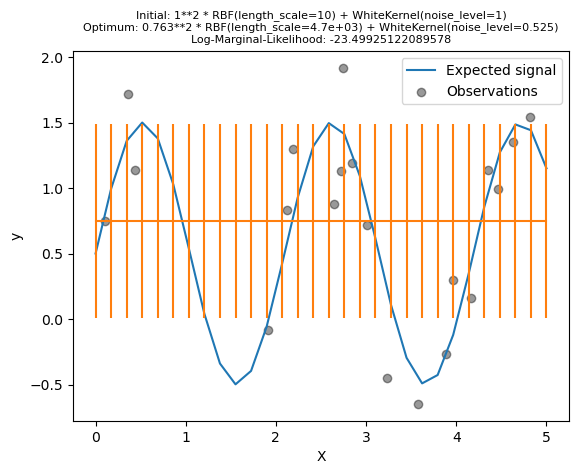

In [13]:
# create a GaussianProcessRegressor with an additive kernel adding a RBF and WhiteKernel kernels. 
# WhiteKernel can estimate the noise in the data.
# RBF will fit the non-linearity between the data and the target.
# We will show that the hyperparameter space contains several local minima. It will highlights the importance of initial hyperparameter values.
# create a model using a kernel with a high noise level and a large length scale, which will explain all variations in the data by noise.

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e4)) + WK( # changed upper bound from 1e3 to 1e4 to remove convergence warning
    noise_level=1, noise_level_bounds=(1e-5, 1e1))

gpr = GPR(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

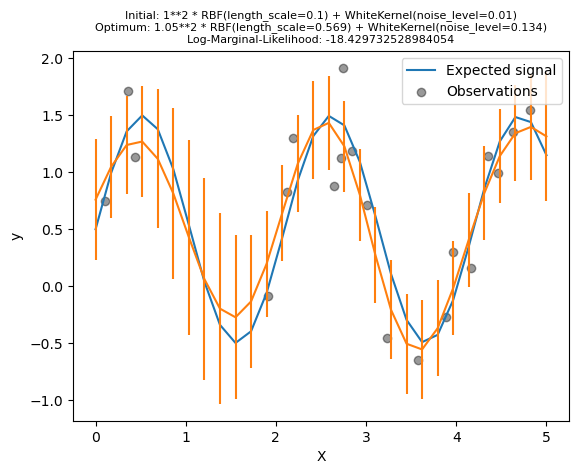

In [15]:
# The optimum kernel still has a high noise level and an even larger length scale. The model does not provide faithful predictions.
# Initialize the RBF with a larger length_scale and the WhiteKernel with a smaller noise level lower bound.

kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WK(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GPR(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

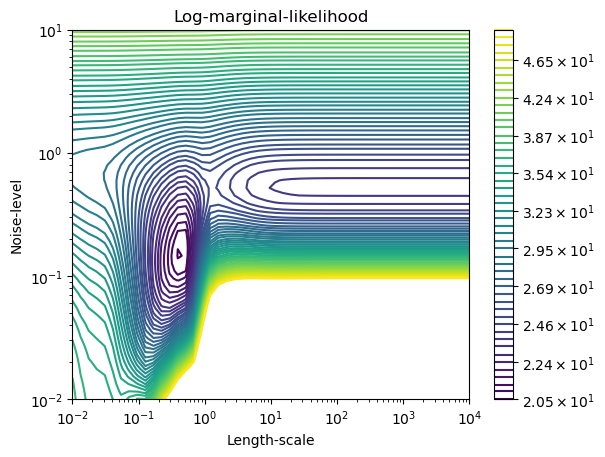

In [16]:
# predictions are more precise - this new model is able to estimate the noise-free functional relationship.
# The best combination of hyperparameters has a smaller noise level and shorter length scale than the first model.
# Inspect the GPR's Log-Marginal-Likelihood (LML) for different hyperparameters to get a sense of the local minima.

from matplotlib.colors import LogNorm

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()


- We see that there are two local minima corresponding to the combination of hyperparameters previously found.
- Gradient-based optimization may not converge to the best model. It is thus important to repeat the optimization with different initializations.

### [example: GPR vs Kernel Ridge Regression](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py)
- GPR and KRR learn target functions by using the __kernel trick__.
- KRR learns a linear function corresponding to a non-linear function in the original space. The linear function is based on MSE (mean squared error) loss with ridge regularization.
- GPR defines a __Gaussian posterior distribution__ using Bayes’ theorem. Thus prior probabilities are combined with a __likelihood function__ defined by training data to provide estimates of the posterior distributions.


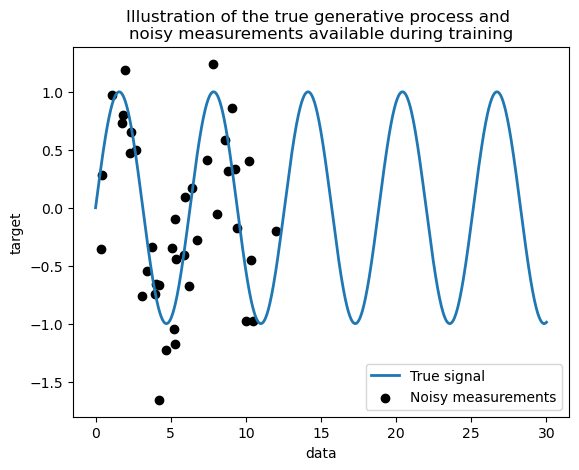

In [2]:
# generate a sine wave dataset
import numpy as np
rng    = np.random.RandomState(0)
data   = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

# challenges: 1) noise, 2) only samples from beginning of signal are available.
training_sample_indices = rng.choice(np.arange(0, 400), 
                                     size=40, 
                                     replace=False)
training_data           = data[training_sample_indices]
training_noisy_target   = target[training_sample_indices] + 0.5 * rng.randn(len(training_sample_indices))

# plot
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training")

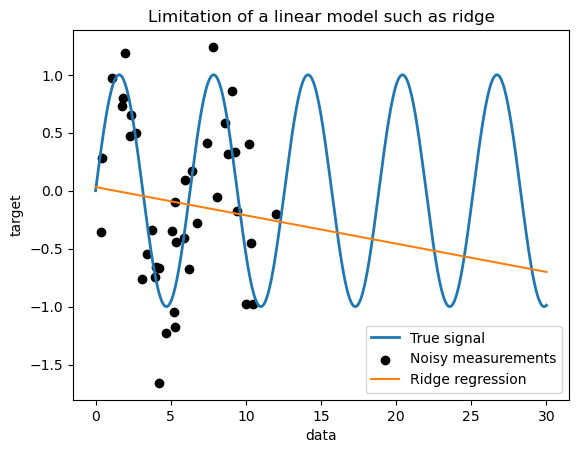

In [3]:
# illustrate limitations of linear model on this data
# fit a Ridge model
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

Fitting KernelRidge with default kernel: 0.002 seconds


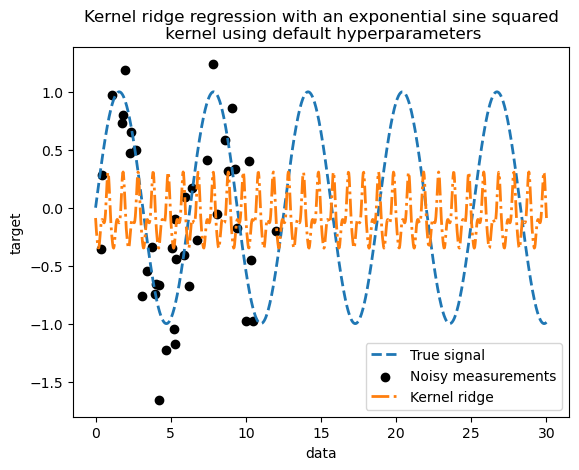

In [4]:
# improve with a kernel (maps original data to new, more complex space).
# we know the generative function is periodic;
# ExpSineSquared kernel allows recovering the periodicity.
# KernelRidge accepts this kernel.

import time
from sklearn.gaussian_process.kernels import ExpSineSquared as ESS
from sklearn.kernel_ridge import KernelRidge as KR

kernel_ridge = KR(kernel=ESS())
start_time   = time.time()
kernel_ridge.fit(training_data, training_noisy_target)
print(
    f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds"
)

plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    kernel_ridge.predict(data),
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters")

In [5]:
# not great. what kernel params did we use?
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

In [7]:
# kernel has 2 params: length-scale, periodicity.
# dataset uses 2pi periodicity.
# use random search to find optimal alpha & kernel params.

from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 1.443 seconds


In [9]:
# model fit = more expensive. which did the search find?
kernel_ridge_tuned.best_params_
# note how periodicity is much closer to expected value of 2pi.

{'alpha': 1.9915849773450223,
 'kernel__length_scale': 0.7986499491396728,
 'kernel__periodicity': 6.607275806426108}

In [10]:
# see improved predictions
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(data)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.005 seconds


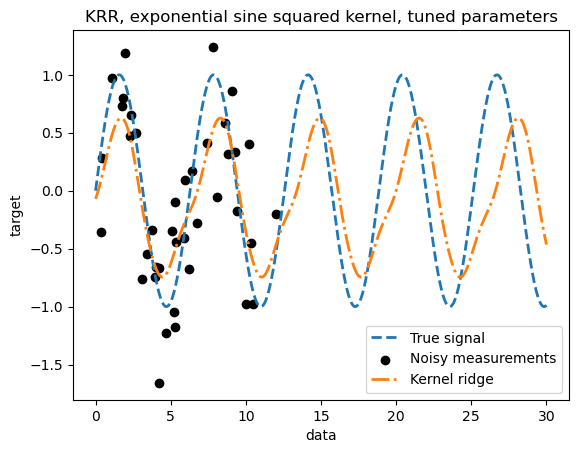

In [11]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "KRR, exponential sine squared kernel, tuned parameters")

In [12]:
# better - noise errors still present.
# now fit using GPR. kernel params are optimized during fit.
# add a WhiteKernel to estimate dataset noise.

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import WhiteKernel as WK

kernel           = 1.0 * ESS(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WK(1e-1)
gaussian_process = GPR(kernel=kernel)
start_time       = time.time()
gaussian_process.fit(training_data, training_noisy_target)
print(f"GPR fit time: {time.time() - start_time:.3f} seconds")

GPR fit time: 0.043 seconds


In [13]:
# improved fit time. what are the optimized params?
gaussian_process.kernel_

0.675**2 * ExpSineSquared(length_scale=1.34, periodicity=6.57) + WhiteKernel(noise_level=0.182)

GPR predict time: 0.003 seconds


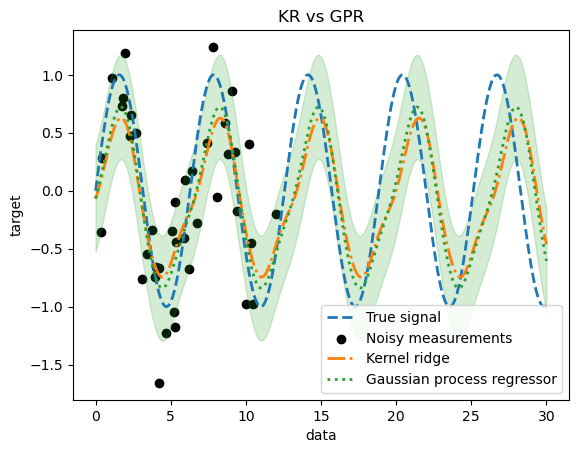

In [15]:
# updated prediction:
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)
print(f"GPR predict time: {time.time() - start_time:.3f} seconds")

plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("KR vs GPR")

- The results of the kernel ridge and the Gaussian process regressor are close.
- GPR also provides uncertainty information that is not available with a kernel ridge. Due to the probabilistic design of the target functions, GPR can output the standard deviation (or the covariance) and mean predictions of the target functions.
- The compute time is higher with a Gaussian process.

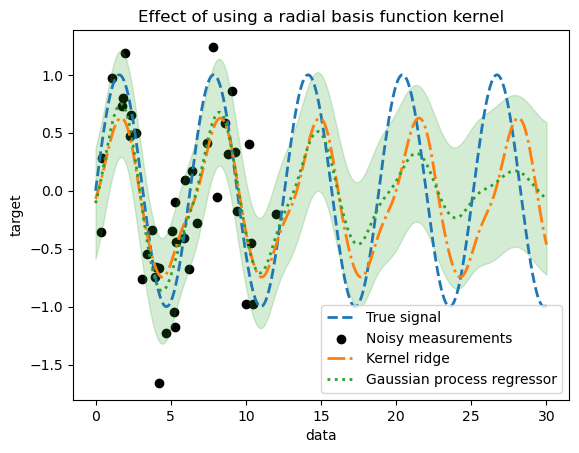

In [16]:
# Above: we only provided the beginning of the signal as a training set. 
# Periodic kernels force our models to repeat the pattern found on the 
# training set. Using this kernel information together with the capacity 
# of the both models to extrapolate, we learn the models will continue to 
# predict the sine pattern.

# Gaussian processes allow to combine kernels.
# We could associate the ESS kernel with an RBF kernel.

from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ESS(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed") + WK(1e-1)

gaussian_process = GPR(kernel=kernel)
gaussian_process.fit(training_data, training_noisy_target)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True)

plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Effect of using a radial basis function kernel")

- Using an RBF kernel attenuates the periodicity effect once no samples are available in the training. As testing samples get further away from the training ones, predictions are converging towards their mean and their standard deviation also increases.

### [example: Mauna Loa CO2 forecasting with GPR](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)
- goal: model CO2 concentration (ppm) as a function of time - extrapolate for years after 2001.

In [17]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, 
                   as_frame=True, 
                   parser="pandas")
co2.frame.head()

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/41187. Retrying...
  warn(


,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [18]:
# create a date index; select CO2 column
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


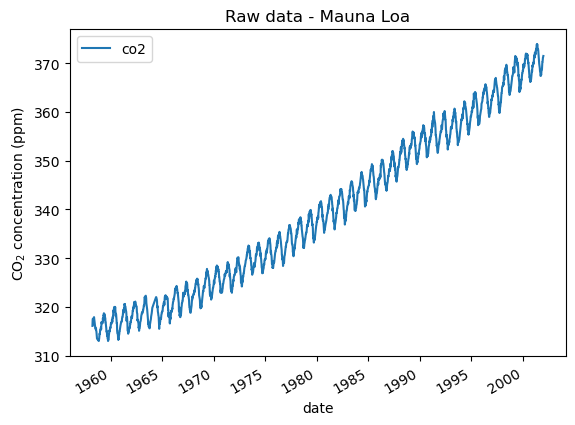

In [19]:
# plot raw info
import matplotlib.pyplot as plt

co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw data - Mauna Loa")

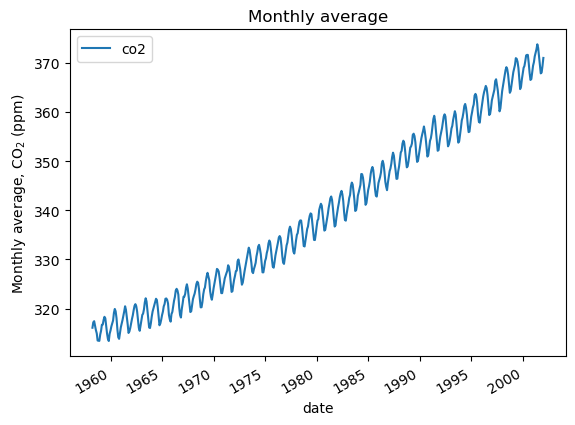

In [20]:
# get monthly averages; drop months with no data (smoothing)
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average, CO$_2$ (ppm)")
_ = plt.title("Monthly average")

In [21]:
# convert date info to numeric
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

In [23]:
# make assumptions about the data:
# long term rising trend
# seasonal variation
# some smaller irregularities. 

from sklearn.gaussian_process.kernels import RBF
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [24]:
# seasonal variation can be explained by the periodic ESS kernel 
# with a fixed periodicity of 1 year. 
# length-scale (controlling its smoothness), is a free parameter. 
# In order to allow decaying away from exact periodicity, 
# the product with an RBF kernel is taken. 
# The length-scale controls the decay time and is a further free parameter. 
# This type of kernel is also known as locally periodic kernel.
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ESS(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed"))

In [25]:
# The small irregularities can be explained by a rational quadratic (RQ) kernel 
# whose length-scale and alpha parameter, which quantifies the diffuseness 
# of the length-scales, are to be determined. 
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ

irregularities_kernel = 0.5**2 * RQ(length_scale=1.0, alpha=1.0)

In [26]:
# Dataset noise can be modeled using an RBF kernel, which explains 
# correlated noise components such as local weather, 
# and a white kernel for white noise. 
# The relative amplitudes and the RBF’s length scale are further 
# free parameters.
from sklearn.gaussian_process.kernels import WhiteKernel as WK

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WK(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

In [27]:
# final kernel = combination of all the previous ones.
co2_kernel = (
    long_term_trend_kernel + 
    seasonal_kernel + 
    irregularities_kernel + 
    noise_kernel)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [28]:
# model fit using GPR
# subtract the mean from the target. 
# we could have used normalize_y=True. 
# However, doing so would have also scaled the target 
# (dividing y by its standard deviation). 
# Thus, the hyperparameters of the different kernel would have 
# had different meaning since they would not have been expressed in ppm.

from sklearn.gaussian_process import GaussianProcessRegressor as GPR

y_mean = y.mean()
gaussian_process = GPR(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [29]:
# inspect the goodness of fit;
# create synth data from 1958 to current month
# add subtracted mean computed during training.

import datetime
import numpy as np

today         = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test        = np.linspace(start=1958, 
                            stop=current_month, 
                            num=1_000).reshape(-1, 1)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, 
                                                   return_std=True)
mean_y_pred += y_mean

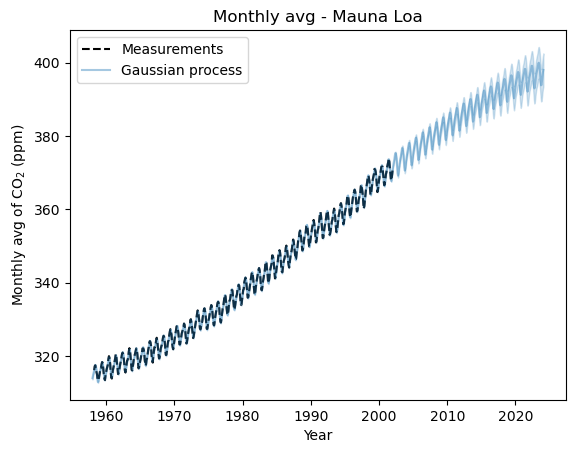

In [30]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly avg of CO$_2$ (ppm)")
_ = plt.title(
    "Monthly avg - Mauna Loa")

In [31]:
# kernel params
gaussian_process.kernel_

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

### [Gaussian Process Classifiers (GPCs)](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc)
- GPC enables __probabilistic classification__.
- It places a GP prior on a __latent function__ which is squashed through a __link function__ to get the probabilistic classification.
- The latent function is a so-called __nuisance function__, whose values are not observed and not relevant by themselves. It allows a convenient formulation of the model, and is removed (integrated out) during prediction. - GPC implements a __logistic link__ function for which the integral cannot be computed analytically but is easily approximated in the binary case.

- The posterior of the latent function is not Gaussian even for a GP prior since a Gaussian likelihood is inappropriate for discrete class labels.
- A non-Gaussian likelihood corresponding to the logistic link function (logit) is used instead.
- GPC approximates the non-Gaussian posterior with a Gaussian based on the Laplace approximation. More details can be found in Chapter 3 of [RW2006].
- The GP prior mean is assumed to be zero. The prior’s covariance is specified by passing a kernel object. The hyperparameters are optimized during fitting of GPR by maximizing the log-marginal-likelihood (LML) based on the passed optimizer.
- The LML may have multiple local optima - so the optimizer can be started repeatedly with __n_restarts_optimizer__. The first run always the initial hyperparameter values; subsequent runs are chosen randomly from a range of allowed values. If the initial hyperparameters should be kept fixed, ``None`` can be passed as optimizer.

- GPC supports multi-class classification with OVR or OVO training.
    - OVR: one binary GPC is fitted for each class, which is trained to separate this class from the rest.
    - OVO: one binary GPC is fitted for each pair of classes, which is trained to separate these two classes. The predictions of these binary predictors are combined into multi-class predictions.
    - OVO might be computationally cheaper - it solves many problems involving only a subset of the whole training set. GPC scales cubically with the size of the dataset, this might be considerably faster.
    - However, OVO does not support predicting probability estimates but only plain predictions.
    - GPC does not (yet) implement a true multi-class Laplace approximation internally, but as discussed above is based on solving several binary classification tasks internally, which are combined using one-versus-rest or one-versus-one.


### [example: GPC probability predictions](https://scikit-learn.org/stable/modules/gaussian_process.html#gpc-examples)
- This illustrates the predicted probability of GPC for an RBF kernel with various hyperparameters.
- 1st figure: predicted probability of GPC with arbitrary hyperparameters and with hyperparameters corresponding to the __maximum log-marginal-likelihood__ (LML).
    - While the hyperparameters chosen by optimizing LML have a considerably larger LML, they perform worse according to the log-loss on test data.
    - The figure shows this is because they exhibit a steep change of the class probabilities at the class boundaries (which is good) but have predicted probabilities close to 0.5 far away from the class boundaries (which is bad).
    - This undesirable effect is caused by the Laplace approximation used internally by GPC.
- 2nd figure: displays the LML for different choices of the kernel’s hyperparameters, highlighting the two choices of the hyperparameters used in the first figure by black dots.

LML (initial): -17.598
LML (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


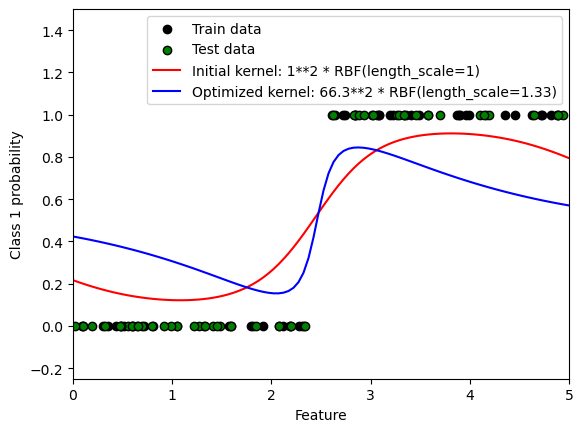

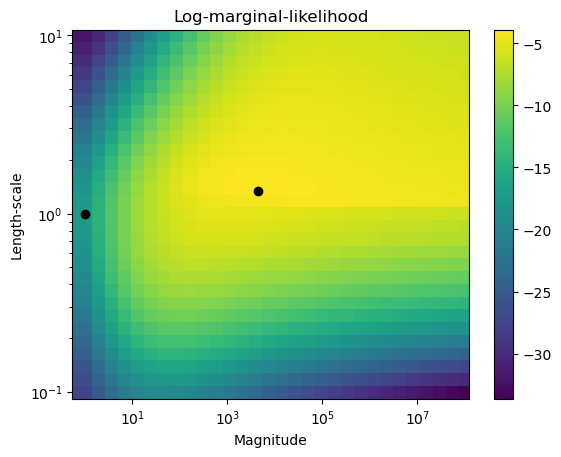

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, log_loss

# Generate data
train_size = 50
rng        = np.random.RandomState(0)
X          = rng.uniform(0, 5, 100)[:, np.newaxis]
y          = np.array(X[:, 0] > 2.5, dtype=int)

# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GPC(kernel=1.0 * RBF(length_scale=1.0), optimizer=None)
gp_opt = GPC(kernel=1.0 * RBF(length_scale=1.0))

gp_fix.fit(X[:train_size], y[:train_size])
gp_opt.fit(X[:train_size], y[:train_size])

print("LML (initial): %.3f"
    % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("LML (optimized): %.3f"
    % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))
print(
    "Accuracy: %.3f (initial) %.3f (optimized)"
    % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
       accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))
print(
    "Log-loss: %.3f (initial) %.3f (optimized)"
    % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
       log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))

# Plot posteriors
plt.figure()
plt.scatter(
    X[:train_size, 0], 
    y[:train_size], 
    c="k", label="Train data", edgecolors=(0, 0, 0))
plt.scatter(
    X[train_size:, 0], 
    y[train_size:], 
    c="g", label="Test data", edgecolors=(0, 0, 0))

X_ = np.linspace(0, 5, 100)
plt.plot(
    X_,
    gp_fix.predict_proba(X_[:, np.newaxis])[:, 1],
    "r", label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(
    X_,
    gp_opt.predict_proba(X_[:, np.newaxis])[:, 1],
    "b", label="Optimized kernel: %s" % gp_opt.kernel_)

plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

# Plot LML landscape
plt.figure()
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [
    [
        gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])
    ]
    for j in range(Theta0.shape[1])
]
LML = np.array(LML).T
plt.plot(
    np.exp(gp_fix.kernel_.theta)[0], 
    np.exp(gp_fix.kernel_.theta)[1], 
    "ko", zorder=10)
plt.plot(
    np.exp(gp_opt.kernel_.theta)[0], 
    np.exp(gp_opt.kernel_.theta)[1], 
    "ko", zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")
plt.show()

### [example: GPC on XOR dataset](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_xor.html)
- Compared are a stationary, isotropic kernel (RBF) and a non-stationary kernel (DotProduct).
- The DotProduct kernel results are considerably better - the class-boundaries are linear and coincide with the coordinate axes. In general, stationary kernels often obtain better results.

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


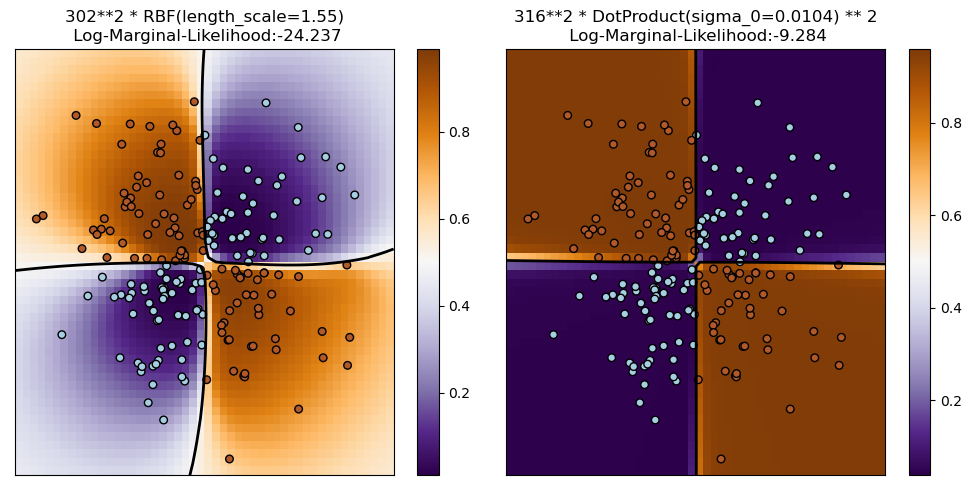

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF, DotProduct as DP

xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng    = np.random.RandomState(0)
X      = rng.randn(200, 2)
Y      = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
plt.figure(figsize=(10, 5))
kernels = 1.0 * RBF(length_scale=1.15), 1.0 * DP(sigma_0=1.0) ** 2
for i, kernel in enumerate(kernels):
    clf = GPC(kernel=kernel, 
              warm_start=True).fit(X, Y)

    # plot decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), 
                                     yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i + 1)
    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r)
    
    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=["k"])
    plt.scatter(X[:, 0], 
                X[:, 1], 
                s=30, c=Y, 
                cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(
        "%s\n Log-Marginal-Likelihood:%.3f"
        % (clf.kernel_, clf.log_marginal_likelihood(clf.kernel_.theta)),
        fontsize=12,
    )

plt.tight_layout()
plt.show()

### [example: GPC on Iris toy dataset](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_iris.html)
- This illustrates the predicted probability of GPC for an isotropic and anisotropic RBF kernel on a 2D version for the iris dataset.
- The anisotropic RBF kernel obtains slightly higher LML by assigning different length-scales to the two feature dimensions.

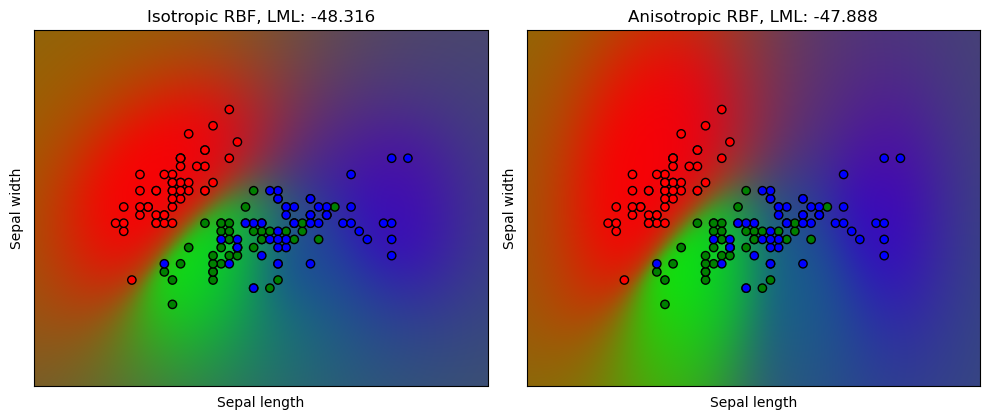

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF

iris   = datasets.load_iris()
X      = iris.data[:, :2]  # we only take the first two features.
y      = np.array(iris.target, dtype=int)
h      = 0.02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GPC(kernel=kernel).fit(X, y)

kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GPC(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].

    plt.subplot(1, 2, i + 1)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y], edgecolors=(0, 0, 0))
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(
        "%s, LML: %.3f" % (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta))
    )

plt.tight_layout()
plt.show()

### [Gaussian process kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)
- Kernels, aka “covariance functions” in the context of GPs) determine the shape of a GP's prior and posterior.
- They encode the function being learned by __defining the “similarity” of two datapoints combined with the assumption that similar datapoints should have similar target values.__
- Two categories of kernels can be distinguished:
    - __stationary__ kernels depend only on the distance of two datapoints; not their values. They are therefore invariant to translations in the input space.
    - __non-stationary__ kernels also use the values of the datapoints.
- Stationary kernels can be subdivided into __isotropic__ and __anisotropic__ kernels. isotropic kernels are also invariant to rotations in the input space.

### Kernel API
- The __call__ method can be used to compute the __auto-covariance__ of all pairs of datapoints in a 2d array X, or the __cross-covariance__ of all combinations of datapoints of a 2d array X with datapoints in a 2d array Y. - If only the diagonal of the auto-covariance is being used, __diag()__ can be used instead. It is more computationally efficient than the equivalent call to __call__.

- Kernels are described by a vector of hyperparameters. They can for instance control length-scales or periodicity.

- The base class for all kernels is __Kernel__. It uses a similar interface as __BaseEstimator__ with methods ``get_params()``, ``set_params()``, and ``clone()``.
- This allows setting kernel values with meta-estimators such as __Pipeline__ or __GridSearchCV__.
- Due to the nested structure of kernels (by applying kernel operators, see below), parameter names can become complicated.
    - For a binary kernel operator, parameters of the left operand are prefixed with ``k1__`` and parameters of the right operand with ``k2__``.

- __clone_with_theta(theta)__ returns a cloned version of the kernel but with the hyperparameters set to theta. An illustrative example:

In [35]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = ConstantKernel(constant_value=1.0, 
                        constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))

for hyperparameter in kernel.hyperparameters: print(hyperparameter)
params = kernel.get_params()
for key in sorted(params): print("%s : %s" % (key, params[key]))
print(kernel.theta)  # Note: log-transformed
print(kernel.bounds)  # Note: log-transformed

Hyperparameter(name='k1__k1__constant_value', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k1__k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
k1 : 1**2 * RBF(length_scale=0.5)
k1__k1 : 1**2
k1__k1__constant_value : 1.0
k1__k1__constant_value_bounds : (0.0, 10.0)
k1__k2 : RBF(length_scale=0.5)
k1__k2__length_scale : 0.5
k1__k2__length_scale_bounds : (0.0, 10.0)
k2 : RBF(length_scale=2)
k2__length_scale : 2.0
k2__length_scale_bounds : (0.0, 10.0)
[ 0.         -0.69314718  0.69314718]
[[      -inf 2.30258509]
 [      -inf 2.30258509]
 [      -inf 2.30258509]]


/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


### [Constant kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel)
- can be used with a product kernel to scale the magnitude of the other factor.
- can be used with a sum kernel to modify the mean of a Gaussian

### Kernel operators ([Sum](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Sum.html#sklearn.gaussian_process.kernels.Sum), [Product](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Product.html#sklearn.gaussian_process.kernels.Product), [Exponentiation](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Exponentiation.html#sklearn.gaussian_process.kernels.Exponentiation))
- kernel operators combine 1 or 2 base kernels.
- Sum: $k_sum(X,Y) = k_1(X,Y) + k_2(X,Y)$
- Product: $k_product(X,Y) = k_1(X,Y) * k_2(X,Y)$
- Exponent: $k_exp(X,Y) = k(X,Y)^p$  where $p$ is a scalar.

### [Radial basis function (RBF) kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF)
- stationary kernel, also known as the "squared exponential" kernel.
- params: length-scale $l>0$ - can be a scalar (isotropic kernel) or a vector of same size as inputs $x$ (anisotropic kernel).
- $k(x_i,x_j) = exp(-d(x_i,x_j)^2 / 2l^2)$ - $d$ is a Euclidean distance.

### [Matern kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern)
- stationary kernel - a generalization of the RBF kernel.
- additional param $v$ controls resulting function "smoothness". This enables adapting the kernel to the properties of the underlying "true" function.
- also uses $l>0$ to control length-scale. 

### [Rational quadratic kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic)
- can be seen as a mixture of RBF kernels with different length-scales.
- params: length-scale $l>0$, and scale mixture $\alpha>0$
- $k(x_i,x_j) = (1+(d(x_i,x_j)^2 / 2\alpha l^2))^-\alpha$

### [Exp-Sine-Squared kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared)
- allows modeling periodic functions
- params: length-scale $l>0$ and periodicity $p>0$.
- $k(x_i,x_j) = exp(- 2 sin^2 (\pi d(x_i,x_j)/p / l^2)$

### [Dot-product kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html#sklearn.gaussian_process.kernels.DotProduct)
- non-stationary; invariant to rotations around the origin; not invariant to translations.
- $k(x_i,x_j) = \theta^2_0 + x_i . x_j $
- commonly combined with exponentiation.

### [example: prior & posterior Gaussians for different kernels](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html)
- The mean, std deviation and 5 samples are shown for the prior and posterior distributions.

In [40]:
# helper function - plots samples drawn from gaussian

import matplotlib.pyplot as plt
import numpy as np

def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])

In [37]:
# generate dataset
rng = np.random.RandomState(4)
X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
n_samples = 5

### RBF

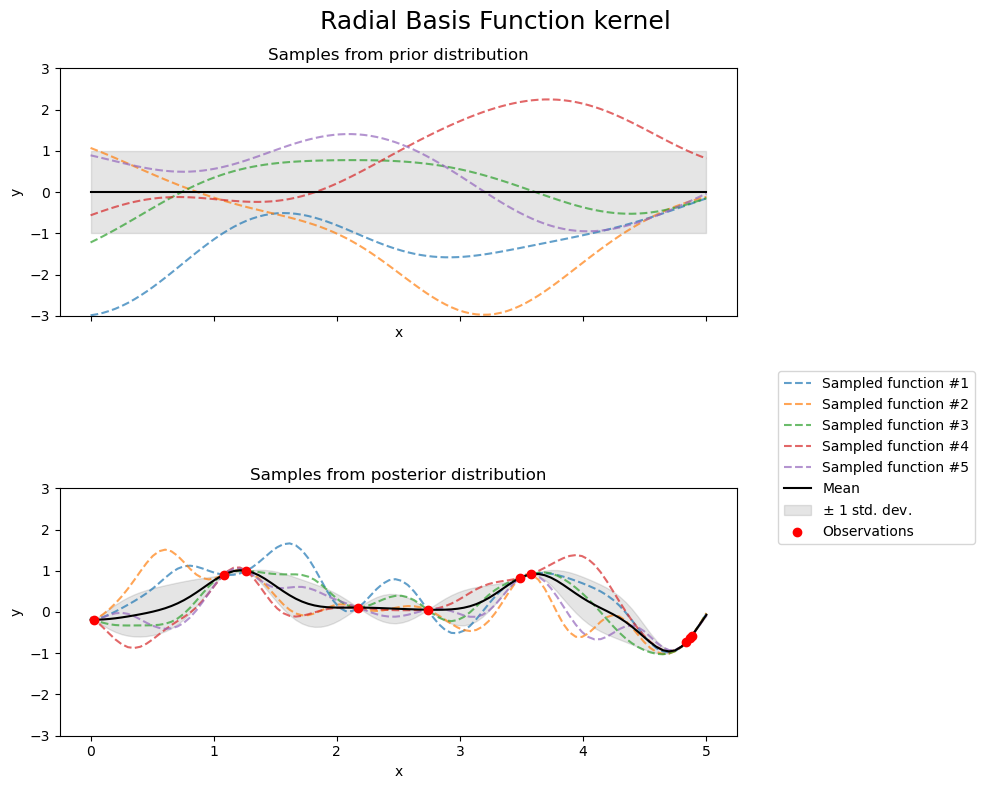

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr = GPR(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

In [42]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)

Kernel parameters before fit:
1**2 * RBF(length_scale=1))
Kernel parameters after fit: 
0.594**2 * RBF(length_scale=0.279) 
Log-likelihood: -0.067


### Rational Quadratic kernel

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:526: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


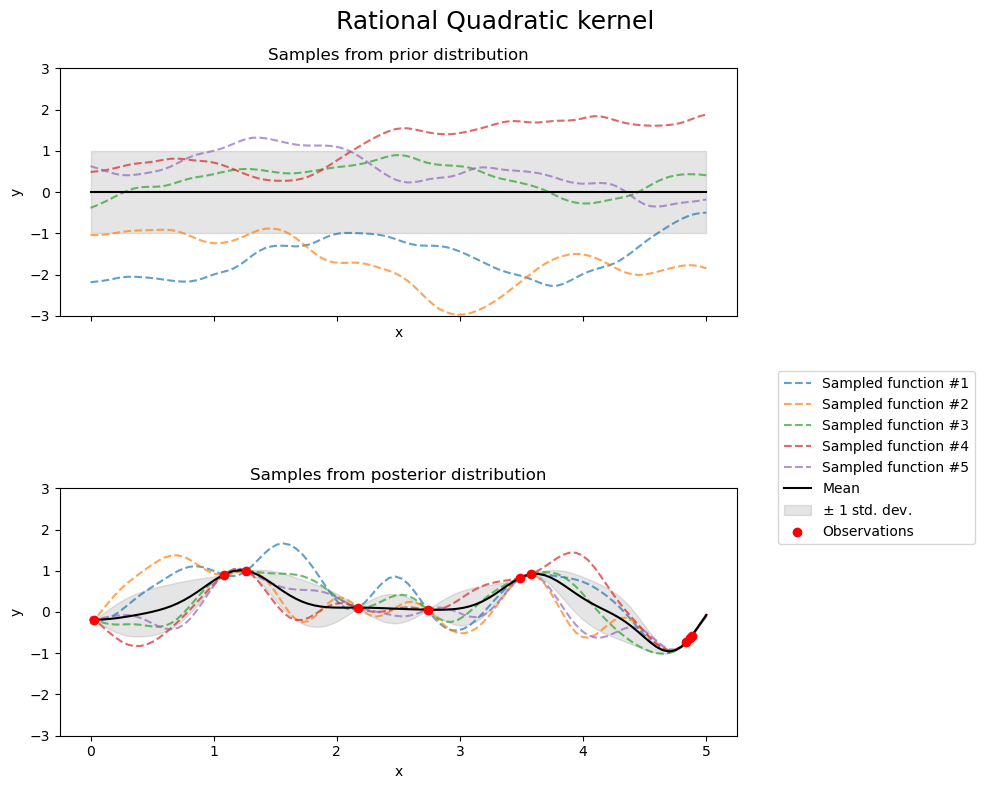

In [44]:
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ

kernel = 1.0 * RQ(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
gpr    = GPR(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Rational Quadratic kernel", fontsize=18)
plt.tight_layout()

In [45]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")

Kernel parameters before fit:
1**2 * RationalQuadratic(alpha=0.1, length_scale=1))
Kernel parameters after fit: 
0.594**2 * RationalQuadratic(alpha=3.41e+07, length_scale=0.279) 
Log-likelihood: -0.067


### Exp-Sine-Squared kernel

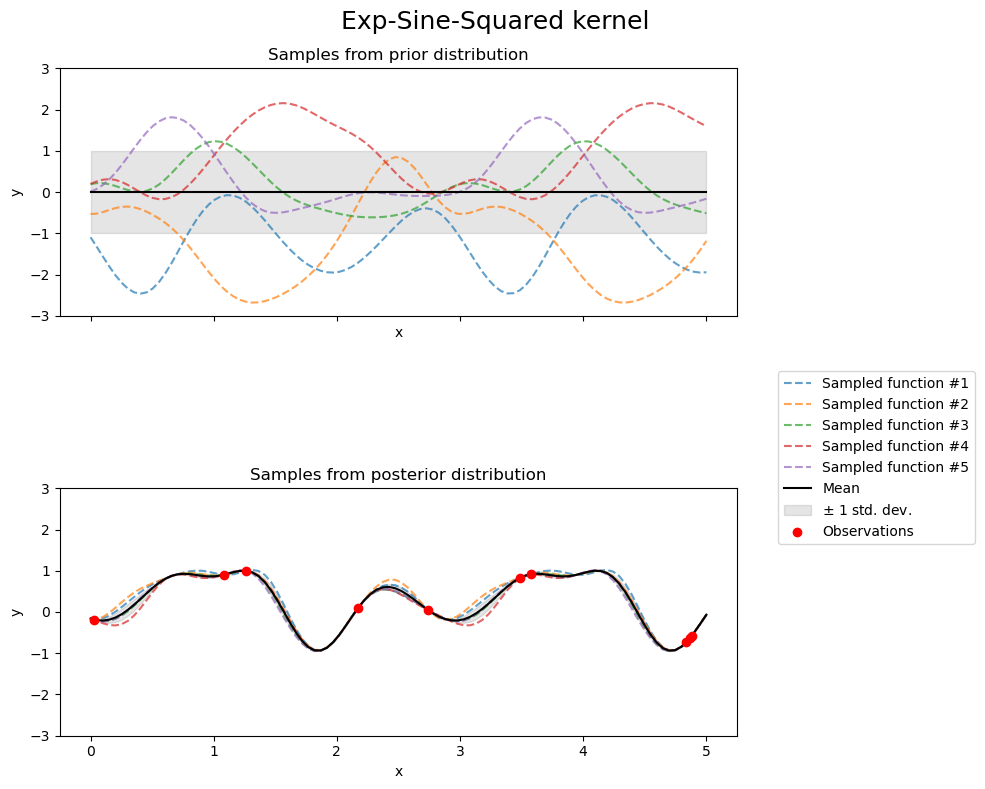

In [46]:
from sklearn.gaussian_process.kernels import ExpSineSquared as ESS

kernel = 1.0 * ESS(
    length_scale=1.0,
    periodicity=3.0,
    length_scale_bounds=(0.1, 10.0),
    periodicity_bounds=(1.0, 10.0))
gpr = GPR(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Exp-Sine-Squared kernel", fontsize=18)
plt.tight_layout()

In [47]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")

Kernel parameters before fit:
1**2 * ExpSineSquared(length_scale=1, periodicity=3))
Kernel parameters after fit: 
0.799**2 * ExpSineSquared(length_scale=0.791, periodicity=2.87) 
Log-likelihood: 3.394


### Dot-product kernel

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


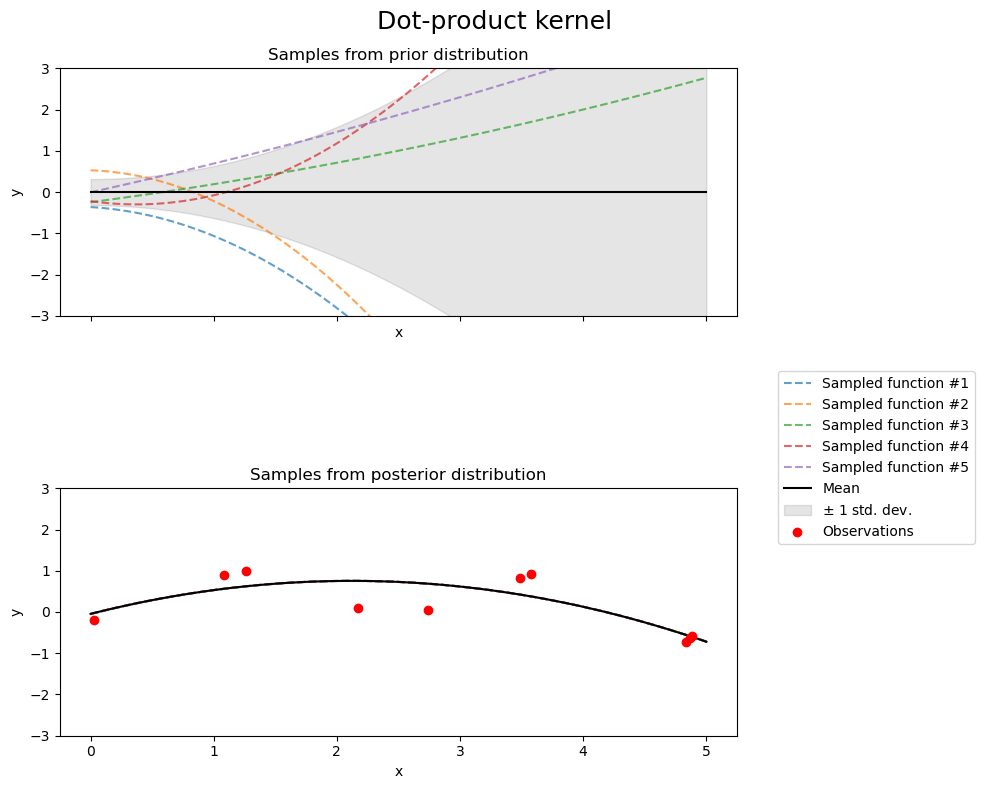

In [49]:
from sklearn.gaussian_process.kernels import ConstantKernel as CK, DotProduct as DP

kernel = CK(0.1, (0.01, 10.0)) * (
    DP(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)

gpr = GPR(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Dot-product kernel", fontsize=18)
plt.tight_layout()

In [50]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)

Kernel parameters before fit:
0.316**2 * DotProduct(sigma_0=1) ** 2)
Kernel parameters after fit: 
0.674**2 * DotProduct(sigma_0=2.13) ** 2 
Log-likelihood: -7957695978.947


### Matern kernel

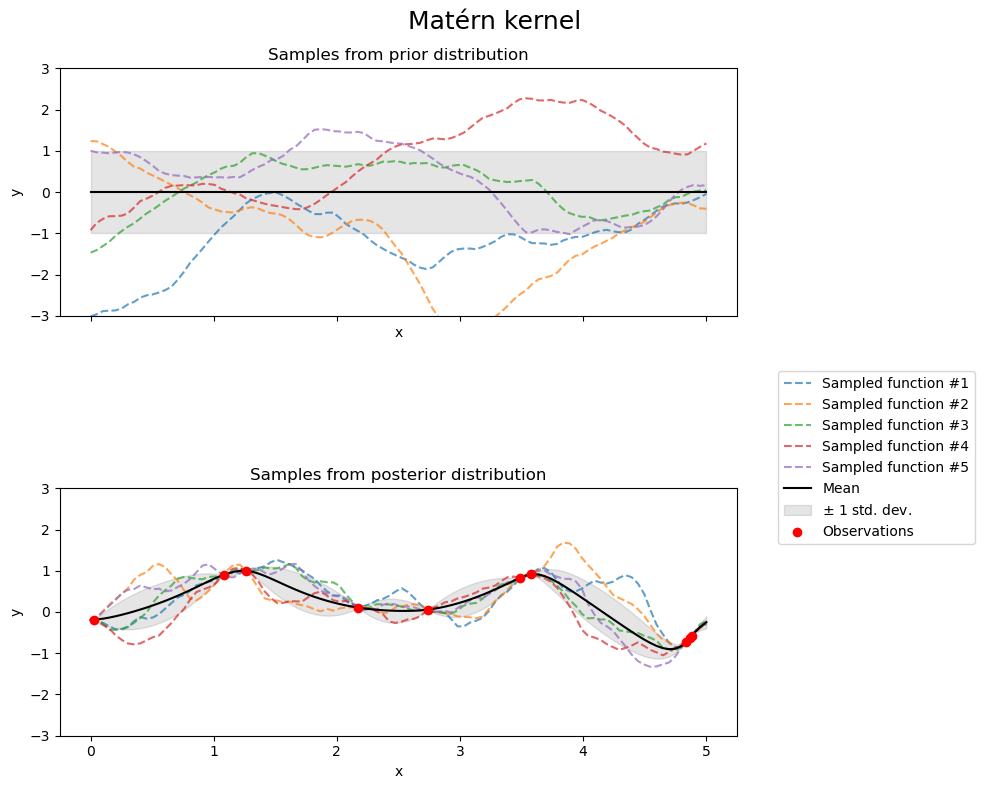

In [51]:
from sklearn.gaussian_process.kernels import Matern

kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gpr = GPR(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Matérn kernel", fontsize=18)
plt.tight_layout()

In [52]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)

Kernel parameters before fit:
1**2 * Matern(length_scale=1, nu=1.5))
Kernel parameters after fit: 
0.609**2 * Matern(length_scale=0.484, nu=1.5) 
Log-likelihood: -1.185
